<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [38]:
import numpy as np
import pandas as pd
import copy
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [39]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [40]:
def entropy(y):
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return -1 * np.dot(P, np.log2(P))

def gini(y):
    P = [len(y[y==k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(P, P)

# Regression criterion functions
def variance(y):
    return np.var(y)

def mad_median(y):
    return np.mean(np.abs(y-np.median(y)))

# Dictionary for easy mapping with input string
criterion_dict = {'entropy': entropy,
                   'gini': gini,
                   'mse': variance,
                   'mad_median' : mad_median}

In [41]:
def classification_leaf(y):
    return np.bincount(y).argmax()

def regression_leaf(y):
    return np.mean(y)

In [42]:
class Node():

    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

In [43]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        
        self.max_depth = max_depth
        self.__max_depth_cnt__ = 0
        self.min_samples_split = min_samples_split
        self.debug = debug   
        self.criterion = criterion 
        self.__tree__ = Node()
        self.__targe_unique__ = None
        
    # Подсчет информативнисти
    def __calculation_information__(self, y):
        if self.criterion == 'gini':
            return gini(y)
        elif self.criterion == 'entropy':
            return entropy(y)
        
    #Раздаление numpy матрицы 
    def __split__(self, arr, cond):
        return (arr[cond], arr[~cond])

        
    # Прирорст информации   
    def __information_gain__(self,information, left, right):
        base = left.shape[0] + right.shape[0]
        return information-(
            (left.shape[0]/base*self.__calculation_information__(left))+(right.shape[0]/base*self.__calculation_information__(right)))
    
    def __tree_creation__(self, tree, X, y, depth_cnt):
        
        # Сохраняем значения у 
        tree.values_pred = copy.deepcopy(y)
        
        # Информативность текущего узла 
        tree.information = self.__calculation_information__(y)
        
        
        # Проверка глубины
        if self.max_depth == depth_cnt:
            return 
        
        # Увеличиваем глубину
        depth_cnt+=1
        tree.depth = copy.deepcopy(depth_cnt)
        
        # Проверка значения хаоса
        if tree.information == 0:
            return 
        
        # Проверка глубины
        if self.min_samples_split >= X.shape[0]:
            return 
        
        # Добавление столбца таргет к признакам
        x = np.column_stack((X, y.reshape((-1, 1))[:, 0]))
        
        # Поиск условия с максимальным приростом информации
        best_gain = 0
        best_feature = 0 
        best_val = None

        for feature in range(x.shape[1]-1):
            for val in np.unique(x[:,feature]):
                (left, right) = self.__split__(x,x[:,feature]<val)

                # Условие для исключения пустых потомков
                if left[:,-1].shape[0]!=0 and right[:,-1].shape[0]!=0:
                    next_gain = self.__information_gain__(tree.information, left[:,-1], right[:,-1])
                    if best_gain < next_gain:
                        best_gain = copy.deepcopy(next_gain)
                        best_feature = copy.deepcopy(feature)
                        best_val = copy.deepcopy(val)

        if best_val is None:
            best_val = np.median(x[:,best_feature])
            
        # Сохраняем условия разделения выборки 
        tree.splitting_feature = copy.deepcopy(best_feature)
        tree.splitting_values = copy.deepcopy(best_val)
        
        (left, right) = self.__split__(x,x[:,best_feature]<best_val)
        
              
        # Разбиваем левого потомка 
        tree.left = Node()
        self.__tree_creation__(tree=tree.left, X=left[:,:-1], y=left[:,-1], depth_cnt=tree.depth)
        
        # Разбиваем правого потомка 
        tree.right = Node()
        self.__tree_creation__(tree=tree.right, X=right[:,:-1], y=right[:,-1], depth_cnt=tree.depth)
        
        
    def fit(self, X, y): 
        self.__targe_unique__ = np.unique(y)
        self.__tree_creation__(tree=self.__tree__, X=X, y=y, depth_cnt=self.__max_depth_cnt__)    
    
    def __predict_tree__(self, tree, x):
        
        # Проверка на попадание в лист дерева
        if tree.right is None and tree.left is None:            
            return tree.values_pred
        
        # Проверка условий для левого потомка дерева
        if x[tree.splitting_feature]<tree.splitting_values:
            if tree.left is None:
                return tree.values_pred
            return self.__predict_tree__(tree.left, x)
        
        # Проверка условий для правого потомка дерева 
        else:
            if tree.right is None:
                return tree.values_pred
            return self.__predict_tree__(tree.right, x)
        
    
    def predict(self, X):
        pred = []
        for i in X:
            y = self.__predict_tree__(self.__tree__, i)
            pred.append(stats.mode(y).mode[0])
        return np.array(pred)
        
        
    def predict_proba(self, X):
        pred_prod = np.array([self.__targe_unique__])
        
        for i in X:
            y = self.__predict_tree__(self.__tree__, i)
            pred = np.array([])
            for class_select in self.__targe_unique__:
                class_cnt = np.sum((class_select == y))
                pred = np.append(pred, round(class_cnt/y.shape[0], 4))
            pred_prod = np.vstack([pred_prod, pred])
            
        return np.array(pred_prod[1:])
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
#         pred = self.predict(X)
#         return sum((pred == y))/y.shape[0]


## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [44]:
# Prepare a synthetic data for classification
X, y = make_classification(n_features=2, n_redundant=0, n_samples=400,
                          random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=RANDOM_STATE)

In [45]:
def print_results_clf(model):
    y_pred = model.predict(X_test)
    prob_pred = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy: {0:.2f}".format(accuracy))

    if (sum(np.argmax(prob_pred,axis=1) - y_pred) == 0):
        print('predict_proba works!')

    plt.suptitle("Accuracy = {0:.2f}".format(accuracy))
    plt.subplot(121)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
    plt.title('Predicted class labels')
    plt.axis('equal')
    plt.subplot(122)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
    plt.title('True class labels')
    plt.axis('equal');

Accuracy: 0.87
predict_proba works!


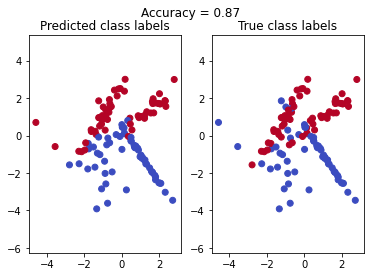

In [46]:
clf1 = DecisionTree(max_depth=4, min_samples_split=2, criterion='entropy')
clf1.fit(X_train, y_train)

print_results_clf(clf1)

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [47]:
kfold = 5

tree_params = {'max_depth': range(3,11),
              'criterion':['entropy', 'gini']}

model = DecisionTree()
tree_grid = GridSearchCV(model, tree_params, cv=kfold, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(3, 11)},
             verbose=True)

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

In [48]:
df_plot = pd.DataFrame(tree_grid.cv_results_['params'])
df_plot['accuracy'] = tree_grid.cv_results_['mean_test_score']

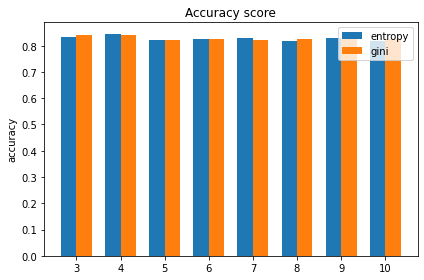

In [49]:
labels = df_plot.max_depth.sort_values().unique()
entropy = df_plot[df_plot.criterion=='entropy'].sort_values('max_depth').accuracy
gini = df_plot[df_plot.criterion=='gini'].sort_values('max_depth').accuracy

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, entropy, width, label='entropy')
rects2 = ax.bar(x + width/2, gini, width, label='gini')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Accuracy score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9].
2. На отрезке [3, 10] построенные графики не пересекаются.
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз.
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`.
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10].

Ответ:
1. Оптимальное значение max_depth для каждого критерия достигается на отрезке [4, 9] (tree_grid.best_params_ =  'max_depth': 8)
2. На отрезке [3, 10] построенные графики не пересекаются.

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Ответ:
ни один из перечисленных
max_depth = 8, criterion = 'entropy';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [50]:
def entropy(y):
    s = 0
    for i in np.unique(y):
        p = np.sum((i == y))/y.shape[0]
        s+=p*np.log2(p)

    return s*(-1)


model = DecisionTree(max_depth=8, criterion='entropy')
model.fit(X_train, y_train)

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127
2. 0.118
3. 1.0
4. 0.09

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [51]:
# Ваш код здесь

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [52]:
# Ваш код здесь

Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

In [53]:
# Ваш код здесь

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз.
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`.

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance';